In [123]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Input 
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

In [124]:

# --- Load NetCDF dataset ---
nc_path = '/Users/bintayislamfathma/Desktop/Machine Learning/SMP_2019Jan_data.nc'  # 🔁 Replace if needed
ds = xr.open_dataset(nc_path, chunks={'Time': 1})  # Ensure chunking is per timestep

# --- Select variables for CNN ---
variables = ['slp', 'U10', 'V10']  

# --- Feature extraction per timestep ---
def extract_features(ds, variables):
    features = []
    timestamps = []
    for t in range(len(ds.Time)):
        row = []
        for var in variables:
            arr = ds[var].isel(Time=t).load().values  # (lat, lon)
            row.append(arr.mean())
            row.append(arr.std())
            row.append(arr.max())
            row.append(arr.min())
            row.append(arr.max() - arr.min())  # range
            row.append(np.abs(np.diff(arr, axis=1)).mean())  # grad_x
            row.append(np.abs(np.diff(arr, axis=0)).mean())  # grad_y
        features.append(row)
        timestamps.append(str(ds.Time.isel(Time=t).values))
        if t % 100 == 0:
            print(f"Processed {t}/{len(ds.Time)}")
    return np.array(features), np.array(timestamps)

# --- Run extraction ---
X, timestamps = extract_features(ds, variables)
print("Extracted features:", X.shape)

# --- Load labels ---
y = np.load('/Users/bintayislamfathma/Desktop/Machine Learning/labels.npy')  
print("Labels shape:", y.shape)

# --- Match features to labels (first 430 timesteps only) ---
X = X[:430]  # Ensure feature count matches label count
timestamps = timestamps[:430]

# --- Normalize and reshape for CNN ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))  # For CNN input

# --- Save for model training ---
np.save('cnn_features.npy', X_cnn)
np.save('cnn_labels.npy', y)
# Define the split variable (example: 80% train, 20% test split)
split = {'train': 0.8, 'test': 0.2}
np.save('cnn_split.npy', split)

# --- Final confirmation ---
print("Final feature shape for CNN:", X_cnn.shape)
print("Final label shape:", y.shape)

Processed 0/744
Processed 100/744
Processed 200/744
Processed 300/744
Processed 400/744
Processed 500/744
Processed 600/744
Processed 700/744
Extracted features: (744, 21)
Labels shape: (430,)
Final feature shape for CNN: (430, 21, 1)
Final label shape: (430,)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Load Features, Labels, and Split ---
X = np.load('/Users/bintayislamfathma/Desktop/Machine Learning/cnn_features.npy')  
y = np.load('/Users/bintayislamfathma/Desktop/Machine Learning/cnn_labels.npy')    
split = np.load('/Users/bintayislamfathma/Desktop/Machine Learning/cnn_split.npy', allow_pickle=True)

# --- Train/Val Split ---
X_train, y_train = X[split == 'train'], y[split == 'train']
X_val, y_val = X[split == 'val'], y[split == 'val']

# --- Reshape to 2D CNN format: (samples, height, width, channels) ---
X_train = X_train.reshape(-1, 7, 3, 1)
X_val = X_val.reshape(-1, 7, 3, 1)

# --- Class Weights ---
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

# --- CNN Model ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2], 1)),  # (height, width, channels)

    Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),  
    Dropout(0.3),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Train ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    class_weight=class_weights
)

# --- Evaluate ---
y_pred_proba = model.predict(X_val).flatten()
y_pred = (y_pred_proba > 0.65).astype(int)

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba):.4f}")


🔹 Overall Metrics:
  Accuracy:  0.8571
  Precision (Event): 0.7857
  Recall    (Event): 1.0000
  F1 Score  (Event): 0.8800
  AUC-ROC:   0.9773

📊 Classification Report:
               precision    recall  f1-score   support

Non-event (0)       1.00      0.70      0.82        20
    Event (1)       0.79      1.00      0.88        22

     accuracy                           0.86        42
    macro avg       0.89      0.85      0.85        42
 weighted avg       0.89      0.86      0.85        42



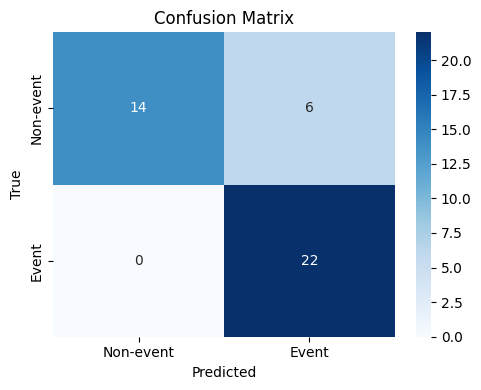

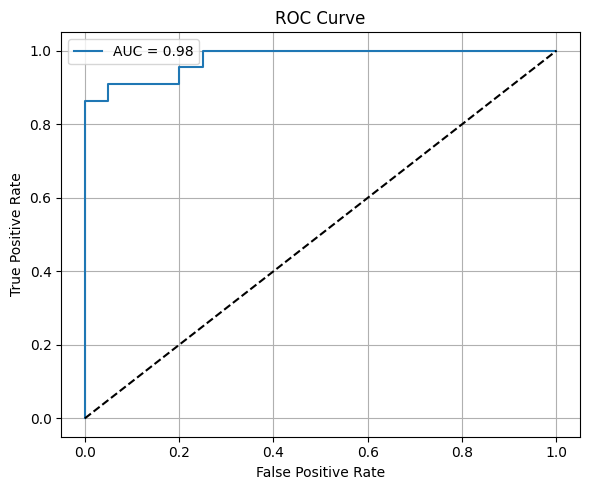

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# --- Overall Metrics ---
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, zero_division=0)
rec = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)
auc = roc_auc_score(y_val, y_pred_proba)

print(" Overall Metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (Event): {prec:.4f}")
print(f"  Recall    (Event): {rec:.4f}")
print(f"  F1 Score  (Event): {f1:.4f}")
print(f"  AUC-ROC:   {auc:.4f}")

# --- Classification Report for both classes ---
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Non-event (0)", "Event (1)"], zero_division=0))

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-event', 'Event'],
            yticklabels=['Non-event', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

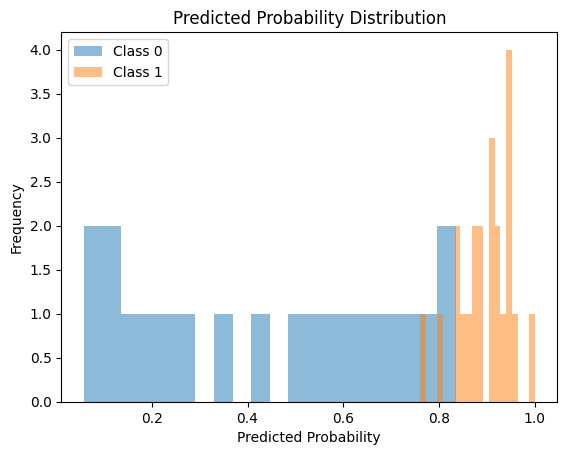

In [107]:
import matplotlib.pyplot as plt

plt.hist(y_pred_proba[y_val == 0], bins=20, alpha=0.5, label='Class 0')
plt.hist(y_pred_proba[y_val == 1], bins=20, alpha=0.5, label='Class 1')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Predicted Probability Distribution")
plt.legend()
plt.show()


In [110]:
# Total PLs in ground truth
true_positives = sum((y_val == 1) & (y_pred == 1))   # correctly predicted PLs
false_positives = sum((y_val == 0) & (y_pred == 1))  # wrongly predicted PLs
total_predicted_pls = sum(y_pred == 1)               # all predicted PLs
total_actual_pls = sum(y_val == 1)                   # ground truth PLs

print(f"✔️ True PLs in validation set: {total_actual_pls}")
print(f"🔍 PLs correctly detected (True Positives): {true_positives}")
print(f"⚠️ False PL detections (False Positives): {false_positives}")
print(f"📈 Total predicted PLs: {total_predicted_pls}")


✔️ True PLs in validation set: 22
🔍 PLs correctly detected (True Positives): 22
⚠️ False PL detections (False Positives): 6
📈 Total predicted PLs: 28
